<a href="https://colab.research.google.com/github/NaveenNKD2001/Bounding-Box-Prediction-and-Object-Classification/blob/main/yolo_bounding_box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from shutil import copy
from glob import glob
from xml.etree import ElementTree as et
import pandas as pd
import numpy as np
import cv2

In [3]:
xml=glob('/content/drive/MyDrive/drive_folder/Object_detection_dataset/annotations/*.xml')

In [4]:
len(xml)

877

In [5]:
xml[0]

'/content/drive/MyDrive/drive_folder/Object_detection_dataset/annotations/road129.xml'

In [ ]:
#xml=list(map(lambda x: x.replace('\\','/'),xml))

In [ ]:
#xml[0]

In [6]:
def extract_txt(filename):
    tree=et.parse(filename) # parses an XML object into element tree object which allows you to access and manipulate the elements and attributes of the XML document
    root=tree.getroot()

    image_name=root.find('filename').text
    width=int(root.find('size/width').text)
    height=int(root.find('size/height').text)
    label_name=root.find('object/name').text
    x_min=int(root.find('object/bndbox/xmin').text)
    x_max=int(root.find('object/bndbox/xmax').text)
    y_min=int(root.find('object/bndbox/ymin').text)
    y_max=int(root.find('object/bndbox/ymax').text)

    return [image_name,width,height,label_name,x_min,x_max,y_min,y_max]

In [7]:
parsed_data=[extract_txt(x) for x in xml]

In [8]:
del xml

In [9]:
parsed_data[:10]

[['road129.png', 400, 267, 'crosswalk', 111, 211, 76, 171],
 ['road130.png', 400, 281, 'crosswalk', 162, 181, 30, 50],
 ['road127.png', 400, 265, 'crosswalk', 268, 312, 56, 101],
 ['road121.png', 400, 301, 'speedlimit', 157, 379, 25, 250],
 ['road13.png', 267, 400, 'trafficlight', 75, 195, 74, 348],
 ['road111.png', 400, 267, 'speedlimit', 35, 101, 92, 159],
 ['road100.png', 400, 385, 'speedlimit', 35, 363, 5, 326],
 ['road115.png', 400, 225, 'speedlimit', 141, 244, 63, 161],
 ['road114.png', 400, 247, 'speedlimit', 254, 319, 32, 102],
 ['road1.png', 400, 283, 'trafficlight', 154, 258, 63, 281]]

In [10]:
df=pd.DataFrame(parsed_data,columns=['image_name','width','height','label','xmin','xmax','ymin','ymax'])

In [11]:
del parsed_data

In [12]:
df.head()

,image_name,width,height,label,xmin,xmax,ymin,ymax
0,road129.png,400,267,crosswalk,111,211,76,171
1,road130.png,400,281,crosswalk,162,181,30,50
2,road127.png,400,265,crosswalk,268,312,56,101
3,road121.png,400,301,speedlimit,157,379,25,250
4,road13.png,267,400,trafficlight,75,195,74,348


In [13]:
df['label'].unique()

array(['crosswalk', 'speedlimit', 'trafficlight', 'stop'], dtype=object)

In [14]:
d={'crosswalk':0, 'speedlimit':1, 'trafficlight':2, 'stop':3}

In [15]:
df['label']=[d[i] for i in df['label']]

In [16]:
df.head()

,image_name,width,height,label,xmin,xmax,ymin,ymax
0,road129.png,400,267,0,111,211,76,171
1,road130.png,400,281,0,162,181,30,50
2,road127.png,400,265,0,268,312,56,101
3,road121.png,400,301,1,157,379,25,250
4,road13.png,267,400,2,75,195,74,348


In [17]:
df['center_x']=((df['xmin']+df['xmax'])/2)/df['width']
df['center_y']=((df['ymin']+df['ymax'])/2)/df['height']
df['w']=(df['xmax']-df['xmin'])/df['width']
df['h']=(df['ymax']-df['ymin'])/df['height']

In [18]:
df.head()

,image_name,width,height,label,xmin,xmax,ymin,ymax,center_x,center_y,w,h
0,road129.png,400,267,0,111,211,76,171,0.402500,0.462547,0.250000,0.355805
1,road130.png,400,281,0,162,181,30,50,0.428750,0.142349,0.047500,0.071174
2,road127.png,400,265,0,268,312,56,101,0.725000,0.296226,0.110000,0.169811
3,road121.png,400,301,1,157,379,25,250,0.670000,0.456811,0.555000,0.747508
4,road13.png,267,400,2,75,195,74,348,0.505618,0.527500,0.449438,0.685000


In [19]:
img_df=pd.DataFrame(df['image_name'],columns=['image_name'])

In [20]:
img_train=tuple(img_df.sample(frac=0.8)['image_name'])
img_test=tuple(img_df.query(f'image_name not in {img_train}')['image_name'])

In [21]:
len(img_train),len(img_test)

(702, 175)

In [22]:
train_df=df.query(f'image_name in {img_train}')
test_df=df.query(f'image_name in {img_test}')

In [23]:
del img_df,img_train,img_test,df

In [24]:
train_df.head()

,image_name,width,height,label,xmin,xmax,ymin,ymax,center_x,center_y,w,h
0,road129.png,400,267,0,111,211,76,171,0.402500,0.462547,0.250000,0.355805
1,road130.png,400,281,0,162,181,30,50,0.428750,0.142349,0.047500,0.071174
2,road127.png,400,265,0,268,312,56,101,0.725000,0.296226,0.110000,0.169811
3,road121.png,400,301,1,157,379,25,250,0.670000,0.456811,0.555000,0.747508
4,road13.png,267,400,2,75,195,74,348,0.505618,0.527500,0.449438,0.685000


In [25]:
test_df.head()

,image_name,width,height,label,xmin,xmax,ymin,ymax,center_x,center_y,w,h
5,road111.png,400,267,1,35,101,92,159,0.17000,0.470037,0.1650,0.250936
9,road1.png,400,283,2,154,258,63,281,0.51500,0.607774,0.2600,0.770318
10,road103.png,400,301,1,89,297,25,272,0.48250,0.493355,0.5200,0.820598
23,road117.png,400,225,1,224,289,32,103,0.64125,0.300000,0.1625,0.315556
25,road131.png,400,267,0,156,177,8,31,0.41625,0.073034,0.0525,0.086142


In [26]:
os.mkdir('/content/drive/MyDrive/drive_folder/images_labels_yolo')

os.mkdir('/content/drive/MyDrive/drive_folder/images_labels_yolo/train')
os.mkdir('/content/drive/MyDrive/drive_folder/images_labels_yolo/test')

os.mkdir('/content/drive/MyDrive/drive_folder/images_labels_yolo/train/images')
os.mkdir('/content/drive/MyDrive/drive_folder/images_labels_yolo/train/labels')

os.mkdir('/content/drive/MyDrive/drive_folder/images_labels_yolo/test/images')
os.mkdir('/content/drive/MyDrive/drive_folder/images_labels_yolo/test/labels')

In [27]:
train_folder='/content/drive/MyDrive/drive_folder/images_labels_yolo/train'
test_folder='/content/drive/MyDrive/drive_folder/images_labels_yolo/test'

In [28]:
cols=['image_name','label','center_x','center_y','w','h']
group_train=train_df[cols].groupby('image_name')
group_test=test_df[cols].groupby('image_name')

In [29]:
group_train

In [30]:
group_train.get_group('road10.png')

,image_name,label,center_x,center_y,w,h
15,road10.png,2,0.4375,0.498127,0.345,0.973783


In [31]:
def save_data(image_name,folder_path,group_obj):
    try:
        src=os.path.join('/content/drive/MyDrive/drive_folder/Object_detection_dataset/images',image_name)
        dest=os.path.join(folder_path,'images',image_name)
        copy(src,dest)

        text_filename=os.path.join(folder_path,'labels',os.path.splitext(image_name)[0]+'.txt')
        group_obj.get_group(image_name).set_index('image_name').to_csv(text_filename,sep=' ',index=False,header=False)

    except Exception as e:
        print('filename',image_name)
        print('e',e)

In [32]:
train_filename_series=pd.Series(group_train.groups.keys())
test_filename_series=pd.Series(group_test.groups.keys())

In [33]:
train_filename_series.apply(save_data,args=(train_folder,group_train))

0      None
1      None
2      None
3      None
4      None
       ... 
697    None
698    None
699    None
700    None
701    None
Length: 702, dtype: object

In [34]:
test_filename_series.apply(save_data,args=(test_folder,group_test))

0      None
1      None
2      None
3      None
4      None
       ... 
170    None
171    None
172    None
173    None
174    None
Length: 175, dtype: object

In [35]:
def remove_spaces(d):
    files=os.listdir(d)

    for file_name in files:
        if file_name.endswith('.txt') and ' ' in file_name:
            new_file_name=file_name.replace(' ','')
            old_path=os.path.join(d,file_name)
            new_path=os.path.join(d,new_file_name)

            os.rename(old_path,new_path)
            print(old_path,'-->',new_path)

In [36]:
remove_spaces('/content/drive/MyDrive/drive_folder/images_labels_yolo/train/labels')

In [37]:
remove_spaces('/content/drive/MyDrive/drive_folder/images_labels_yolo/test/labels')

In [38]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 6.2 MB/s eta 0:00:00


In [39]:
from ultralytics import YOLO
import yaml

model=YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 53.1MB/s]


In [40]:
data={
    'train':'/content/drive/MyDrive/drive_folder/images_labels_yolo/train',
    'val':'/content/drive/MyDrive/drive_folder/images_labels_yolo/test',
    'nc':4,
    'names':[0, 1, 2, 3]
}

with open('/content/drive/MyDrive/drive_folder/data.yaml','w') as file:
    yaml.dump(data,file)

In [ ]:
# with open('data.yaml','r') as file:
#     data=yaml.safe_load(file)

In [41]:
model.train(data='/content/drive/MyDrive/drive_folder/data.yaml',epochs=100)

Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/drive_folder/data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/drive_folder/images_labels_yolo/train/labels... 702 images, 0 backgrounds, 0 corrupt: 100%|██████████| 702/702 [00:08<00:00, 80.17it/s] 


train: New cache created: /content/drive/MyDrive/drive_folder/images_labels_yolo/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/drive_folder/images_labels_yolo/test/labels... 175 images, 0 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:02<00:00, 62.94it/s]


val: New cache created: /content/drive/MyDrive/drive_folder/images_labels_yolo/test/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.39G     0.7311      2.762     0.9529         37        640: 100%|██████████| 44/44 [00:27<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]

                   all        175        175      0.944      0.107      0.539      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.25G     0.7405      1.657     0.9331         23        640: 100%|██████████| 44/44 [00:23<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

                   all        175        175      0.475      0.476      0.558      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.26G      0.769      1.615     0.9495         26        640: 100%|██████████| 44/44 [00:22<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]

                   all        175        175      0.678      0.486      0.518      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.25G     0.7313      1.393     0.9438         19        640: 100%|██████████| 44/44 [00:21<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all        175        175      0.515      0.561      0.552      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.25G     0.7097      1.256     0.9436         21        640: 100%|██████████| 44/44 [00:21<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

                   all        175        175      0.774      0.537      0.575       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.25G     0.6785      1.123     0.9313         22        640: 100%|██████████| 44/44 [00:22<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        175        175      0.733      0.754      0.763      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.25G     0.6828      1.019     0.9331         28        640: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all        175        175       0.69      0.599      0.599      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.25G     0.6536     0.9513     0.9256         25        640: 100%|██████████| 44/44 [00:23<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        175        175      0.662      0.724      0.744      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.25G     0.6724      0.902     0.9228         25        640: 100%|██████████| 44/44 [00:20<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

                   all        175        175      0.724      0.828       0.78      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.25G     0.6798     0.8538     0.9286         32        640: 100%|██████████| 44/44 [00:21<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.88it/s]

                   all        175        175       0.73      0.736      0.732      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.25G     0.6402     0.8086     0.9181         35        640: 100%|██████████| 44/44 [00:21<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


                   all        175        175      0.728      0.742      0.759      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.25G     0.6375      0.733     0.9148         31        640: 100%|██████████| 44/44 [00:23<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        175        175      0.804       0.76      0.831      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.25G     0.6213     0.7143      0.901         31        640: 100%|██████████| 44/44 [00:22<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]

                   all        175        175       0.65      0.791      0.721      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.25G      0.611     0.7181     0.9192         21        640: 100%|██████████| 44/44 [00:21<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]

                   all        175        175      0.832      0.719      0.815      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.25G     0.6082     0.6877     0.9093         27        640: 100%|██████████| 44/44 [00:21<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]

                   all        175        175      0.729      0.761      0.732      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.25G     0.5975     0.6757     0.9009         27        640: 100%|██████████| 44/44 [00:21<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]

                   all        175        175      0.747        0.8      0.806      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.25G     0.6099     0.6487     0.9061         21        640: 100%|██████████| 44/44 [00:22<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

                   all        175        175      0.672      0.812      0.768      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.25G     0.5967      0.656     0.9079         25        640: 100%|██████████| 44/44 [00:23<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


                   all        175        175      0.838      0.752      0.791      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.25G     0.5915     0.6534     0.9002         28        640: 100%|██████████| 44/44 [00:23<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        175        175      0.857      0.722      0.792      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.25G     0.5866     0.6148     0.8884         24        640: 100%|██████████| 44/44 [00:21<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all        175        175      0.761      0.749      0.817      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.25G     0.5602     0.5788     0.8829         23        640: 100%|██████████| 44/44 [00:20<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

                   all        175        175      0.736      0.716      0.747      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.25G     0.5879     0.6073     0.9089         27        640: 100%|██████████| 44/44 [00:21<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all        175        175      0.663      0.757      0.759      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.25G     0.5668     0.5734     0.9036         22        640: 100%|██████████| 44/44 [00:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        175        175      0.808      0.723      0.779      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.25G     0.5698     0.5717     0.8902         28        640: 100%|██████████| 44/44 [00:22<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]

                   all        175        175      0.695       0.78      0.776      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.25G     0.5853     0.5842     0.9048         20        640: 100%|██████████| 44/44 [00:22<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        175        175      0.762       0.84      0.809      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.25G     0.5721     0.5801     0.8959         28        640: 100%|██████████| 44/44 [00:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        175        175      0.809       0.77      0.805      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.25G     0.5648     0.5593     0.8898         34        640: 100%|██████████| 44/44 [00:21<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all        175        175       0.79      0.797      0.832      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.25G     0.5654     0.5623     0.8862         26        640: 100%|██████████| 44/44 [00:22<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

                   all        175        175      0.763        0.8      0.813       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.25G     0.5519     0.5185     0.8849         29        640: 100%|██████████| 44/44 [00:20<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.75it/s]

                   all        175        175      0.864      0.778      0.845       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.25G     0.5471     0.5026     0.8791         17        640: 100%|██████████| 44/44 [00:20<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        175        175      0.715      0.788      0.813      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.25G     0.5484     0.5202     0.8799         22        640: 100%|██████████| 44/44 [00:22<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

                   all        175        175      0.717      0.778      0.776      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.25G     0.5274     0.4972     0.8729         21        640: 100%|██████████| 44/44 [00:22<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        175        175      0.859      0.783      0.852      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.25G     0.5455     0.5072     0.8807         25        640: 100%|██████████| 44/44 [00:22<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.01it/s]


                   all        175        175      0.708      0.861       0.82      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.25G     0.5535     0.5409     0.8827         30        640: 100%|██████████| 44/44 [00:21<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.76it/s]

                   all        175        175      0.789      0.805      0.833      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.25G     0.5249     0.4984     0.8807         24        640: 100%|██████████| 44/44 [00:20<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all        175        175      0.744      0.861      0.844      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.25G     0.5281     0.4892     0.8706         31        640: 100%|██████████| 44/44 [00:20<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]

                   all        175        175      0.707      0.839      0.821      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.25G     0.5289     0.4897     0.8794         31        640: 100%|██████████| 44/44 [00:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        175        175      0.723       0.76      0.806      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.25G     0.5262     0.4748      0.872         24        640: 100%|██████████| 44/44 [00:22<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        175        175      0.787      0.835      0.846      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.25G     0.5286     0.4755     0.8837         25        640: 100%|██████████| 44/44 [00:22<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

                   all        175        175      0.787       0.78      0.825      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.25G     0.5209     0.4874      0.875         20        640: 100%|██████████| 44/44 [00:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]

                   all        175        175      0.719      0.802      0.797      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.25G     0.5148     0.4733     0.8753         31        640: 100%|██████████| 44/44 [00:20<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.50it/s]

                   all        175        175      0.781      0.783       0.81      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.25G     0.4993      0.474     0.8656         24        640: 100%|██████████| 44/44 [00:21<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.38it/s]

                   all        175        175      0.709      0.823      0.818      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.25G     0.5036     0.4415     0.8646         26        640: 100%|██████████| 44/44 [00:21<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]

                   all        175        175      0.774       0.79      0.827      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.25G     0.5039     0.4549     0.8745         28        640: 100%|██████████| 44/44 [00:23<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        175        175      0.733      0.855      0.833      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.25G     0.4974     0.4544     0.8762         24        640: 100%|██████████| 44/44 [00:22<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all        175        175      0.792      0.791      0.839      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.25G     0.5025     0.4352     0.8654         31        640: 100%|██████████| 44/44 [00:23<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]

                   all        175        175      0.828      0.772       0.84      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.25G     0.4919     0.4541     0.8669         25        640: 100%|██████████| 44/44 [00:22<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]

                   all        175        175      0.733      0.851      0.812      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.25G     0.4875     0.4518     0.8657         30        640: 100%|██████████| 44/44 [00:21<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

                   all        175        175      0.778      0.844      0.839      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.25G     0.4828     0.4181     0.8642         22        640: 100%|██████████| 44/44 [00:22<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]

                   all        175        175      0.783      0.865      0.872      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.25G     0.4972     0.4361     0.8611         28        640: 100%|██████████| 44/44 [00:21<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        175        175       0.79       0.83      0.845      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.25G      0.494     0.4305     0.8686         31        640: 100%|██████████| 44/44 [00:22<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        175        175      0.874      0.764      0.851      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.25G     0.4825     0.4114     0.8558         26        640: 100%|██████████| 44/44 [00:22<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        175        175      0.777      0.856       0.85      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.25G     0.4897     0.4264     0.8566         24        640: 100%|██████████| 44/44 [00:22<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        175        175      0.813      0.799      0.857      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.25G      0.486     0.4242     0.8723         27        640: 100%|██████████| 44/44 [00:23<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        175        175      0.841      0.737      0.806      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.25G     0.4858     0.4057     0.8656         30        640: 100%|██████████| 44/44 [00:22<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

                   all        175        175      0.734      0.789      0.789      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.25G     0.4824     0.4157     0.8567         32        640: 100%|██████████| 44/44 [00:21<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]

                   all        175        175      0.811      0.826      0.831      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.25G     0.4845      0.387     0.8623         23        640: 100%|██████████| 44/44 [00:21<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


                   all        175        175      0.826      0.824      0.852      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.25G     0.4735     0.3897     0.8565         25        640: 100%|██████████| 44/44 [00:21<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        175        175      0.835      0.853      0.864      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.25G     0.4702     0.3831      0.861         20        640: 100%|██████████| 44/44 [00:22<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]

                   all        175        175       0.77      0.815      0.848      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.25G     0.4618     0.3928     0.8472         25        640: 100%|██████████| 44/44 [00:22<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        175        175      0.773      0.877      0.869      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.25G     0.4714     0.3864     0.8589         23        640: 100%|██████████| 44/44 [00:22<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        175        175      0.794      0.825      0.857      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.25G     0.4724     0.3822     0.8585         20        640: 100%|██████████| 44/44 [00:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]

                   all        175        175      0.691      0.854      0.821      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.25G     0.4605     0.3793     0.8556         28        640: 100%|██████████| 44/44 [00:21<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]

                   all        175        175      0.769      0.859      0.854      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.25G      0.452     0.3814     0.8475         29        640: 100%|██████████| 44/44 [00:21<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]

                   all        175        175      0.768      0.807      0.831      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.25G     0.4609     0.3804     0.8591         25        640: 100%|██████████| 44/44 [00:21<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]

                   all        175        175      0.832      0.725      0.784      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.25G     0.4485      0.374     0.8463         27        640: 100%|██████████| 44/44 [00:22<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        175        175       0.78       0.82      0.844      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.25G     0.4573     0.3644     0.8541         29        640: 100%|██████████| 44/44 [00:22<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]

                   all        175        175      0.778      0.873      0.878      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.25G     0.4668     0.3601     0.8592         22        640: 100%|██████████| 44/44 [00:22<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]

                   all        175        175       0.77      0.851      0.859      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.25G     0.4488     0.3626      0.862         29        640: 100%|██████████| 44/44 [00:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


                   all        175        175       0.73      0.859      0.858      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.25G     0.4362     0.3551     0.8496         22        640: 100%|██████████| 44/44 [00:24<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        175        175      0.751      0.838      0.843      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.25G     0.4431     0.3567     0.8564         28        640: 100%|██████████| 44/44 [00:21<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.61it/s]

                   all        175        175      0.797      0.867      0.857      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.25G     0.4342     0.3413     0.8484         25        640: 100%|██████████| 44/44 [00:21<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

                   all        175        175      0.801      0.902      0.875      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.25G     0.4566     0.3526     0.8592         32        640: 100%|██████████| 44/44 [00:20<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        175        175      0.794      0.912      0.892      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.25G     0.4308     0.3363     0.8491         27        640: 100%|██████████| 44/44 [00:22<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        175        175      0.786      0.793      0.859      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.25G     0.4422     0.3551     0.8573         19        640: 100%|██████████| 44/44 [00:22<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        175        175      0.755      0.847      0.852      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.25G     0.4315     0.3534     0.8499         32        640: 100%|██████████| 44/44 [00:22<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        175        175      0.703      0.801      0.828      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.25G     0.4294     0.3454     0.8501         24        640: 100%|██████████| 44/44 [00:23<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all        175        175      0.768      0.842      0.845      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.25G      0.414     0.3306     0.8529         22        640: 100%|██████████| 44/44 [00:21<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.74it/s]

                   all        175        175      0.822       0.81      0.842      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.25G     0.4237     0.3187      0.843         19        640: 100%|██████████| 44/44 [00:21<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all        175        175      0.808      0.888      0.884       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.25G     0.4307     0.3271     0.8511         17        640: 100%|██████████| 44/44 [00:20<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]

                   all        175        175      0.762      0.838      0.855      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.25G     0.4244     0.3409     0.8442         19        640: 100%|██████████| 44/44 [00:21<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        175        175      0.782       0.77      0.837      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.25G     0.4138     0.3202     0.8481         27        640: 100%|██████████| 44/44 [00:22<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

                   all        175        175      0.739      0.896      0.852      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.25G      0.431     0.3312      0.846         24        640: 100%|██████████| 44/44 [00:22<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        175        175      0.725      0.857      0.851      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.25G     0.4259     0.3189     0.8507         25        640: 100%|██████████| 44/44 [00:22<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

                   all        175        175      0.744      0.868      0.859      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.25G     0.4106     0.3054     0.8462         32        640: 100%|██████████| 44/44 [00:22<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]

                   all        175        175      0.788      0.846      0.866      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.25G     0.4066     0.2995     0.8414         28        640: 100%|██████████| 44/44 [00:21<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]

                   all        175        175      0.762      0.804      0.833      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.25G     0.4131     0.3175     0.8493         20        640: 100%|██████████| 44/44 [00:21<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]

                   all        175        175      0.759      0.794      0.832      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.25G     0.4061     0.3114     0.8424         20        640: 100%|██████████| 44/44 [00:21<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

                   all        175        175      0.785      0.835      0.856      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.25G     0.4162      0.304     0.8377         26        640: 100%|██████████| 44/44 [00:22<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        175        175      0.796      0.858      0.862      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.25G     0.3995     0.3035     0.8428         30        640: 100%|██████████| 44/44 [00:22<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        175        175      0.804      0.851      0.857      0.747


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.25G     0.3836     0.2716     0.8059         14        640: 100%|██████████| 44/44 [00:26<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        175        175      0.792      0.827      0.854      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.25G     0.3755     0.2621     0.8096         14        640: 100%|██████████| 44/44 [00:21<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        175        175      0.759      0.832      0.843      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.25G     0.3752     0.2555     0.8031         14        640: 100%|██████████| 44/44 [00:20<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]

                   all        175        175      0.776       0.86      0.867      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.25G     0.3717     0.2459     0.8095         14        640: 100%|██████████| 44/44 [00:20<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]

                   all        175        175      0.777      0.865       0.86       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.25G     0.3639     0.2423     0.8087         14        640: 100%|██████████| 44/44 [00:21<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        175        175      0.782      0.824      0.856      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.25G     0.3611     0.2404     0.8051         14        640: 100%|██████████| 44/44 [00:22<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        175        175      0.803      0.791      0.846      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.25G     0.3711       0.24     0.8083         14        640: 100%|██████████| 44/44 [00:21<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]

                   all        175        175      0.784      0.821      0.847      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.25G     0.3649     0.2411     0.8113         14        640: 100%|██████████| 44/44 [00:20<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]

                   all        175        175      0.781      0.848      0.856      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.25G     0.3501     0.2324     0.8004         14        640: 100%|██████████| 44/44 [00:20<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all        175        175       0.77      0.853      0.863      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.25G     0.3588     0.2317     0.8062         14        640: 100%|██████████| 44/44 [00:22<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


                   all        175        175       0.77      0.851      0.863      0.758

100 epochs completed in 0.738 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]


                   all        175        175      0.809      0.888      0.886      0.773
                     0        175         19      0.651      0.786      0.748      0.677
                     1        175        127      0.864      0.999      0.972      0.907
                     2        175         12      0.828      0.803      0.833      0.546
                     3        175         17      0.891      0.964       0.99      0.964
Speed: 0.4ms preprocess, 4.3ms inference, 0.0ms loss, 9.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c5932b04f70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [42]:
import torch

torch.save(model.state_dict(), '/content/drive/MyDrive/drive_folder/yolo_model.pth')

# loaded_model = Yolo()
# loaded_model.load_state_dict(torch.load('yolo_model.pth'))

In [43]:
test_list=glob('/content/drive/MyDrive/drive_folder/images_labels_yolo/test/images/*.png')

In [44]:
len(test_list)

175

In [46]:
img=cv2.imread(test_list[1])
pred=model(img)


0: 480x640 1 1, 1 2, 458.3ms
Speed: 3.0ms preprocess, 458.3ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)


In [49]:
test_list[1]

'/content/drive/MyDrive/drive_folder/images_labels_yolo/test/images/road1.png'

In [47]:
a=pred[0].boxes

In [48]:
a

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2., 1.], device='cuda:0')
conf: tensor([0.8952, 0.4265], device='cuda:0')
data: tensor([[147.1671,  59.0136, 259.6715, 282.8051,   0.8952,   2.0000],
        [279.5699, 112.7240, 298.6195, 134.0763,   0.4265,   1.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (283, 400)
shape: torch.Size([2, 6])
xywh: tensor([[203.4193, 170.9093, 112.5044, 223.7915],
        [289.0947, 123.4002,  19.0496,  21.3523]], device='cuda:0')
xywhn: tensor([[0.5085, 0.6039, 0.2813, 0.7908],
        [0.7227, 0.4360, 0.0476, 0.0754]], device='cuda:0')
xyxy: tensor([[147.1671,  59.0136, 259.6715, 282.8051],
        [279.5699, 112.7240, 298.6195, 134.0763]], device='cuda:0')
xyxyn: tensor([[0.3679, 0.2085, 0.6492, 0.9993],
        [0.6989, 0.3983, 0.7465, 0.4738]], device='cuda:0')

In [50]:
xywh=a.xywh.cpu().numpy()
l=a.cls[0].cpu().numpy()

In [51]:
x=int(xywh[0][0])
y=int(xywh[0][1])
w=int(xywh[0][2])
h=int(xywh[0][3])

In [52]:
s_p=(x-w//2,y-h//2)
e_p=(x+w//2,y+h//2)

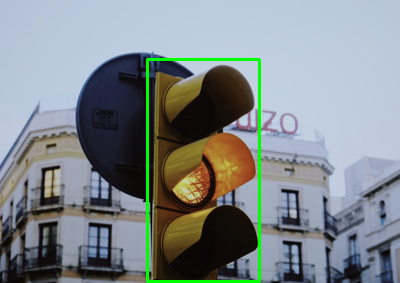

In [53]:
from google.colab.patches import cv2_imshow
cv2.rectangle(img,s_p,e_p,(0,255,0),2)
cv2_imshow(img)

In [54]:
def iou_score_calculator(o,p):
  # area of union
  area_1=(o[2]-o[0])*(o[3]-o[1])
  area_2=(p[2]-p[0])*(p[3]-p[1])

  #area of intersection
  x1=max(o[0],p[0])
  y1=max(o[1],p[1])
  x2=min(o[2],p[2])
  y2=min(o[3],p[3])

  if x2<x1 or y2<y1:
    return 0

  i=(x2-x1)*(y2-y1)

  iou_score=i/(area_1+area_2-i)

  return iou_score

In [55]:
label_path='/content/drive/MyDrive/drive_folder/images_labels_yolo/test/labels'

iou_scores=[]
p_labels=[]
o_labels=[]

for i in test_list:

  image=cv2.imread(i)

  result=model(image)

  if(len(result[0].boxes)==0):
    iou_scores.append(0)
    continue

  l=int(result[0].boxes.cls[0].cpu().numpy())
  p_labels.append(l)

  bb=result[0].boxes.xywh.cpu().numpy()
  x=int(bb[0][0])
  y=int(bb[0][1])
  w=int(bb[0][2])
  h=int(bb[0][3])

  x_min_p=x-w//2
  y_min_p=y-h//2
  x_max_p=x+w//2
  y_max_p=y+h//2
  print('xmin: ',x_min_p," xmax: ",x_max_p," ymin: ",y_min_p," y_max: ",y_max_p)

  box_2=[x_min_p,y_min_p,x_max_p,y_max_p]

  image_n=os.path.split(i)[1]

  x_min_o=test_df.loc[test_df['image_name']==image_n, 'xmin'].values[0]
  y_min_o=test_df.loc[test_df['image_name']==image_n, 'ymin'].values[0]
  x_max_o=test_df.loc[test_df['image_name']==image_n, 'xmax'].values[0]
  y_max_o=test_df.loc[test_df['image_name']==image_n, 'ymax'].values[0]
  o_label=test_df.loc[test_df['image_name']==image_n, 'label'].values[0]

  print('xmin: ',x_min_o," xmax: ",x_max_o," ymin: ",y_min_o," y_max: ",y_max_o)


  box_1=[x_min_o,y_min_o,x_max_o,y_max_o]

  score=iou_score_calculator(box_1,box_2)

  iou_scores.append(score)
  o_labels.append(o_label)


0: 640x448 (no detections), 23.5ms
Speed: 3.9ms preprocess, 23.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 1, 1 2, 29.8ms
Speed: 3.3ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
xmin:  147  xmax:  259  ymin:  59  y_max:  281
xmin:  154  xmax:  258  ymin:  63  y_max:  281

0: 448x640 1 1, 136.5ms
Speed: 5.8ms preprocess, 136.5ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)
xmin:  31  xmax:  243  ymin:  41  y_max:  247
xmin:  37  xmax:  243  ymin:  38  y_max:  245

0: 512x640 1 1, 115.5ms
Speed: 4.5ms preprocess, 115.5ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)
xmin:  81  xmax:  297  ymin:  26  y_max:  272
xmin:  89  xmax:  297  ymin:  25  y_max:  272

0: 608x640 1 1, 118.1ms
Speed: 5.7ms preprocess, 118.1ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)
xmin:  45  xmax:  339  ymin:  26  y_max:  346
xmin:  48  xmax:  344  ymin:  14  y_max:  345

0

In [56]:
len(iou_scores)

175

In [57]:
len(p_labels)

172

In [58]:
len(o_labels)

172

In [59]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print("Accuracy: ",accuracy_score(p_labels,o_labels))
print("Precision: ",precision_score(p_labels,o_labels,average='weighted'))
print("Recall: ",recall_score(p_labels,o_labels,average='weighted'))
print("f1_score: ",f1_score(p_labels,o_labels,average='weighted'))

Accuracy:  0.9127906976744186
Precision:  0.9261078824755229
Recall:  0.9127906976744186
f1_score:  0.9177483824884646


In [60]:
avg_iou_score=sum(iou_scores)/len(iou_scores)

print('Average IOU Score : ',avg_iou_score)

Average IOU Score :  0.8014180690977861
